In [1]:
import requests
from bs4 import BeautifulSoup
import pickle

In [2]:
load_D = True
if load_D:
    URL = 'https://towardsdatascience.com/web-scraping-basics-82f8b5acd45c'
    response = requests.get(URL)
    website_html = response.text
    soup = BeautifulSoup(website_html, "html.parser")
    all_paragraph = soup.find_all(name="p", class_="pw-post-body-paragraph")
    get_only_text = [para.getText() for para in all_paragraph]
    # print(len(get_only_text)) # 40 quite enough
    my_corpus = [text.lower() for text in get_only_text if len(text) > 40 ] 
    with open('hijackdata.atikeep','wb') as tostore:
        pickle.dump(my_corpus,tostore)

## Question 1 Try with new corpus 

In [3]:
with open('hijackdata.atikeep','rb') as readed:
    my_corpus = pickle.load(readed)
print('all document = ',len(my_corpus),'doc, and each document have around',len(my_corpus[-1]),'characters')


all document =  38 doc, and each document have around 113 characters


In [4]:
# for i in my_corpus:
#     print(len(i),'==',i)

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### 0. Init new corpus 


In [6]:
corpus = my_corpus

In [7]:
#1. tokenize
#usually you use spaCy / NLTK to tokenize (but we gonna do this later on, we gonna have spaCy)
corpus_tokenized = [sent.split(" ") for sent in corpus]
# corpus_tokenized  #we called each of this as "tokens", NOT words

In [8]:
#2. numericalize

#2.1 get all the unique words
#we want to flatten this (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))  #vocabs is a term defining all unique words your system know

In [9]:
#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

In [10]:
#add <UNK>, which is a very normal token exists in the world
vocabs.append('<UNK>') #chaky, can it be ##UNK, or UNKKKKKK, or anything
word2index['<UNK>'] = len(vocabs) -1  #usually <UNK> is 0

In [11]:
#create index2word dictionary
#2 min    
index2word = {v:k for k, v in word2index.items()}

# index2word

In [12]:
print(len(vocabs))

468


## 2. Prepare train data
You move the window along, and create those tuples as we said in class

In [13]:
#move along the corpus
#to fit with our corpus, we gonna use window_size = 1

skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(1, len(sent) - 1): #start from 1 to second last
        center_word = sent[i]
        outside_words = [sent[i-1], sent[i+1]]  #window_size = 1
        for o in outside_words:
            skipgrams.append([center_word, o])

# skipgrams
        
#here we want to create (banana, apple), (banana, fruit) append to some list
        

In [14]:
#let's make what we have made into a function (batch function)
#return a batches of data, e.g., =2 --> ['banana', 'apple'], ['banana', 'fruit']
#also i want these batches to be id, NOT token   --> [5, 4]

def random_batch(batch_size, corpus):
    
    skipgrams = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        for i in range(1, len(sent) - 1): #start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+1]]]  #window_size = 1
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)
    

In [15]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[141],
       [299],
       [243],
       [ 68],
       [310],
       [290],
       [110],
       [ 68],
       [ 31],
       [377]])


## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [16]:
voc_size = len(vocabs)
voc_size

468

In [17]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vector for outside words
#v_c - vector for center word
#u_w - vectors of all vocabs

class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size, 1)
        #all_vocabs: (batch_size, voc_size)
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [18]:
#preparing all_vocabs

batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 468])

#### testing the model

In [19]:
input, label = random_batch(batch_size, corpus_tokenized)
input #center word

array([[ 68],
       [363]])

In [20]:
emb_size = 2 #usually, this can be 50, 100, or 300
model = Skipgram(voc_size, emb_size)

In [21]:
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)  #LongTensor basically means integer....#this should give one number
loss = model(input_tensor, label_tensor, all_vocabs)

## Training

In [22]:
batch_size = 2 #why?  no reason; 
emb_size   = 2 #why?  no reason; usually 50, 100, 300, but 2 so we can plot (50 can also plot, but need PCA)
model      = Skipgram(voc_size, emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [23]:
num_epochs = 5000
import time
start_time = time.time()
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} |", "--- %s seconds ---" % (time.time() - start_time))

Epoch 1000 | Loss: 4.978222 | --- 2.329007863998413 seconds ---
Epoch 2000 | Loss: 5.786813 | --- 4.524515867233276 seconds ---
Epoch 3000 | Loss: 8.649696 | --- 6.627592086791992 seconds ---
Epoch 4000 | Loss: 5.553503 | --- 8.879883766174316 seconds ---
Epoch 5000 | Loss: 4.237652 | --- 11.068840980529785 seconds ---


In [24]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()


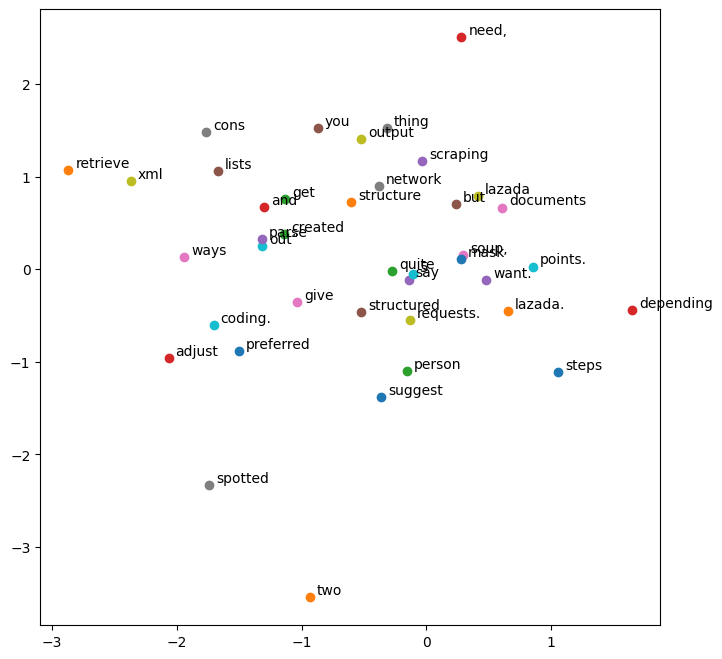

In [25]:
#help me plot fruit cat banana on matplotlib
plt.figure(figsize=(8,8))
for i, word in enumerate(vocabs[:40]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

# Conclude the result of question 1
-

## Question 2 Try with window size = 2

- we need to fix certain part in this function maybe with one more loop
- and change a start and end to be more dynamic

In [26]:
#let's make what we have made into a function (batch function)
#return a batches of data, e.g., =2 --> ['banana', 'apple'], ['banana', 'fruit']
#also i want these batches to be id, NOT token   --> [5, 4]

def random_batch(batch_size, corpus,windowsize = 1):
    
    skipgrams = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        for i in range(windowsize, len(sent) - windowsize): #start from windowsize to windowzie - len
            center_word = word2index[sent[i]]
            '''Change mostly work here both in upper loop and lower loop of this comment'''
            for jk in range(windowsize):
                outside_words = [word2index[sent[i-jk]], word2index[sent[i+jk]]]  #window_size = adaptive
                for o in outside_words:
                    skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)
    

In [27]:
input, label = random_batch(1, corpus_tokenized,2)

print(f"{input.shape}")
print(f"{label=}")

(1, 1)
label=array([[40]])


## Training step

In [31]:
voc_size = len(vocabs)
# voc_size

batch_size = 2 #why?  no reason; 
emb_size   = 2 #why?  no reason; usually 50, 100, 300, but 2 so we can plot (50 can also plot, but need PCA)
model      = Skipgram(voc_size, emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [32]:
num_epochs = 5000
#for epoch
start_time = time.time()
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} |" ,"--- %s seconds ---" % (time.time() - start_time))

Epoch 1000 | Loss: 5.305804 | --- 2.28139591217041 seconds ---
Epoch 2000 | Loss: 2.710355 | --- 4.461694955825806 seconds ---
Epoch 3000 | Loss: 2.750736 | --- 6.525699138641357 seconds ---
Epoch 4000 | Loss: 2.021456 | --- 8.587472915649414 seconds ---
Epoch 5000 | Loss: 1.544300 | --- 10.713836193084717 seconds ---


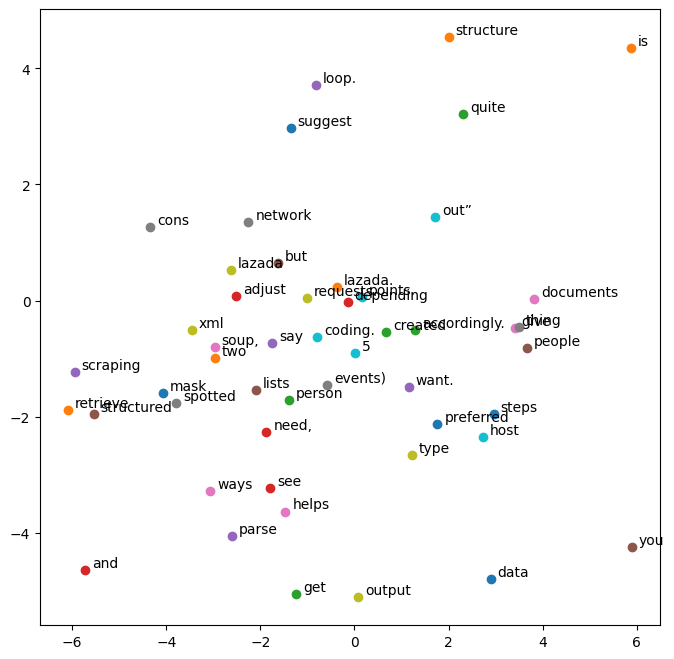

In [33]:
#help me plot fruit cat banana on matplotlib
plt.figure(figsize=(8,8))
for i, word in enumerate(vocabs[:50]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

# Conclude the result of question 2
- 
- 

# Question 3 Im plement CBOW

# Question 4 compare time skipgrams vs. negative sampling version of skipgrams

In [34]:
# prep function 
#let's make what we have made into a function (batch function)
#return a batches of data, e.g., =2 --> ['banana', 'apple'], ['banana', 'fruit']
#also i want these batches to be id, NOT token   --> [5, 4]

def random_batch(batch_size, corpus):
    
    skipgrams = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        for i in range(1, len(sent) - 1): #start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+1]]]  #window_size = 1
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)
    

In [35]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[396],
       [298],
       [ 41],
       [ 68],
       [257],
       [298],
       [305],
       [ 41],
       [304],
       [355]])


## 3. Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words``

In [38]:
#count all the occurrences of vocabs
from collections import Counter
z = 0.001

word_count = Counter(flatten(corpus_tokenized))
# word_count

In [41]:
num_total_words = sum([c for w, c in word_count.items()])
# num_total_words
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha / z)
    # print("vocab: ", v)
    # print("distribution: ", uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
# Counter(unigram_table)

## 4. Negative sampling

A function to get negative samples, based on the current center and outside words in the batch

In [43]:
def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)
    
import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

## 5. Model and  test our method

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [44]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()


In [45]:
input, label = random_batch(batch_size, corpus_tokenized)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [49]:
emb_size = 2 #usually, this can be 50, 100, or 300
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)
#this should give one number
loss = model(input_tensor, label_tensor, neg_tensor)

## 4. Training

In [50]:
voc_size   = len(vocabs)
batch_size = 2 #why?  no reason; 
emb_size   = 2 #why?  no reason; usually 50, 100, 300, but 2 so we can plot (50 can also plot, but need PCA)
model      = SkipgramNeg(voc_size, emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [51]:
num_epochs = 5000
#for epoch
start_time = time.time()
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = model
    loss = model(input_batch, label_batch, neg_batch)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} |", "--- %s seconds ---" % (time.time() - start_time))

Epoch 1000 | Loss: 1.422019 | --- 1.936324119567871 seconds ---
Epoch 2000 | Loss: 1.999828 | --- 3.7658979892730713 seconds ---
Epoch 3000 | Loss: 5.283742 | --- 5.5856640338897705 seconds ---
Epoch 4000 | Loss: 6.966632 | --- 7.404926061630249 seconds ---
Epoch 5000 | Loss: 1.311993 | --- 9.27375316619873 seconds ---
